In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import scraper
import pickle
from pprint import pprint

In [2]:
def priceChanges(prices):
    absChange = [0]*(len(prices)-1)
    percChange = [0]*(len(prices)-1)
    for i in range(0,len(prices)-1):
        absChange[i] = prices[i+1]-prices[i]
        percChange[i] = absChange[i]/prices[i]
    return absChange,percChange

def marginChanges(prices,buylimit):
    absChange = [0]*(len(prices)-1)
    percChange = [0]*(len(prices)-1)
    for i in range(0,len(prices)-1):
        absChange[i] = prices[i+1]*buylimit-prices[i]*buylimit
        percChange[i] = absChange[i]/(prices[i]*buylimit)
    return absChange,percChange

In [99]:
itemInfo = scraper.loadItemInfo()

In [6]:
# calculate high alch items
natPrice = scraper.getExchangeInfo('Nature_rune')['price']
profits = []
for item in itemInfo:
    try:
        #print(int(item['exchangePrice'])+natPrice,int(item['highAlch']))
        exPrice = int(item['exchangePrice'])
        alchPrice = int(item['highAlch'])
        if exPrice!=-1 and exPrice+natPrice < alchPrice:
            #print(item)
            buyLimit = int(item['buyLimit'])
            profits.append((item['name'],alchPrice/(exPrice+natPrice)))
    except ValueError:
        pass
def getKey(item):
    return item[1]
profits.sort(key=getKey,reverse=True)
pprint(profits[:10])

[('Redwood_shield', 1.1671732522796352),
 ('Cyclops_head', 1.1372251705837755),
 ('Snakeskin_shield', 1.0760233918128654),
 ('Zombie_head', 1.0582010582010581),
 ('Mithril_2h_sword', 1.0576271186440678),
 ('Mithril_pickaxe', 1.0441767068273093),
 ('Mithril_kiteshield', 1.0424528301886793),
 ('Snakeskin_chaps', 1.0382916053019147),
 ("Black_d'hide_body", 1.0373220469411313),
 ('Mithril_platebody', 1.0348258706467661)]


In [7]:
itemPrices = scraper.loadItemPrices()

In [8]:
# check length of available datasets
sizes = {}
for item in itemPrices:
    l = len(itemPrices[item])
    if l in sizes:
        sizes[l]+=1
    else:
        sizes[l] = 1
cumSum = 0
cumSums = []
keys = []
for key in sorted(sizes,reverse=True):
    print("%s: %s" % (key, sizes[key]))
    keys.append(key)
    cumSum += sizes[key]
    cumSums.append(cumSum)
cumSums = np.array(cumSums)/cumSum

1346: 1
1342: 107
1341: 353
1340: 9
1339: 31
1338: 27
1337: 21
1336: 13
1335: 28
1334: 23
1333: 8
1332: 5
1331: 7
1330: 2
1329: 8
1328: 4
1327: 9
1326: 7
1325: 5
1324: 4
1323: 5
1322: 3
1321: 4
1320: 491
1319: 52
1318: 104
1317: 90
1316: 108
1315: 78
1314: 76
1313: 101
1312: 34
1311: 61
1310: 45
1309: 36
1308: 41
1307: 57
1306: 60
1305: 23
1304: 45
1303: 26
1302: 19
1301: 21
1300: 18
1299: 26
1298: 12
1297: 15
1296: 11
1295: 15
1294: 14
1293: 8
1292: 21
1291: 8
1290: 17
1289: 17
1288: 12
1287: 7
1286: 14
1285: 14
1284: 4
1283: 13
1282: 11
1281: 9
1280: 6
1279: 7
1278: 3
1277: 4
1276: 11
1275: 9
1274: 12
1273: 8
1272: 8
1271: 3
1270: 1
1269: 5
1268: 6
1267: 4
1266: 4
1265: 4
1264: 2
1263: 4
1262: 5
1261: 5
1260: 5
1259: 8
1258: 2
1257: 5
1256: 3
1255: 3
1254: 7
1252: 4
1251: 3
1250: 1
1249: 1
1248: 4
1247: 4
1246: 2
1245: 2
1244: 13
1243: 1
1242: 3
1241: 3
1240: 3
1239: 2
1238: 6
1237: 2
1236: 10
1235: 4
1234: 2
1233: 2
1232: 3
1231: 4
1230: 8
1229: 7
1228: 1
1227: 2
1226: 1
1224: 8
122

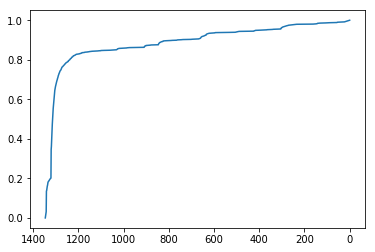

In [9]:
plt.plot(keys,cumSums)
plt.gca().invert_xaxis()

In [13]:
# look at size of quantity data set
sizes = {}
for item in itemPrices:
    l = len([a[2] for a in itemPrices[item] if a[2] > 0])
    if l in sizes:
        sizes[l] +=1
    else:
        sizes[l] = 1
cumSum = 0
cumSums = []
keys = []
for key in sorted(sizes,reverse=True):
    print("%s: %s" % (key, sizes[key]))
    keys.append(key)
    cumSum += sizes[key]
    cumSums.append(cumSum)
cumSums = np.array(cumSums)/cumSum

350: 78
349: 4
346: 2
345: 1
330: 1
325: 1
319: 1
316: 1
306: 1
270: 1
268: 1
243: 1
240: 1
213: 1
191: 2
176: 1
162: 1
157: 1
149: 1
144: 1
136: 1
125: 1
102: 1
96: 1
94: 1
82: 1
80: 1
78: 1
70: 1
69: 1
64: 1
39: 1
37: 1
35: 1
26: 1
24: 1
15: 1
13: 1
12: 1
10: 1
9: 1
7: 1
6: 2
5: 1
4: 2
3: 1
2: 2
1: 2
0: 3256


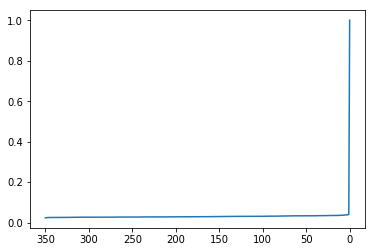

In [14]:
plt.plot(keys,cumSums)
plt.gca().invert_xaxis()

In [28]:
quantItems = []
for item in itemPrices:
    l = len([a[2] for a in itemPrices[item] if a[2] > 0])
    if l>=350:
        quantItems.append(item)

In [29]:
prices = {}
quants = {}
for item in quantItems:
    quant = [a[2] for a in itemPrices[item] if a[2] > 0]
    if len(quant)==350:
        quants[item] = quant
        price = [a[1] for a in itemPrices[item]]
        prices[item] = []
        for i in range(350):
            prices[item].append(price[-350+i])

In [50]:
from sklearn import linear_model

quantItems.sort(key=lambda x: itemPrices[x][-1][1],reverse=True)
scores = {}
for item in quantItems:
    #print(item)
    X = np.array(quants[item][:-1]).reshape(-1, 1)
    y = np.array(prices[item][1:]).reshape(-1, 1)
    
    lm = linear_model.LinearRegression()
    model = lm.fit(X,y)
    predictions = lm.predict(X)
    scores[item] = lm.score(X,y)
    '''
    print(lm.coef_,lm.intercept_)
    plt.scatter(X,y)
    plt.plot(X,predictions,'r')
    plt.show()
    '''
print(sorted(scores.items(), key=lambda kv: kv[1],reverse=True))

[('Arrow_shaft', 1.0), ('Diamond_bolts_(e)', 0.7033147348087457), ('Yew_longbow', 0.6003011013349271), ('Maple_logs', 0.5724270477587146), ('Law_rune', 0.5428130507589966), ('Mithril_dart', 0.5378718981173018), ('Coal', 0.5055455327299649), ('Maple_longbow_(u)', 0.47647099577402985), ('Magic_longbow', 0.43226131152344827), ('Headless_arrow', 0.41826419599325904), ('Trading_sticks', 0.4128604111653211), ('Air_battlestaff', 0.40703135327789786), ('Nature_rune', 0.3596694267505701), ('Grapes', 0.3585064003250237), ('Mithril_arrow', 0.3510571753675682), ('Gold_bar', 0.32172192816523815), ('Cosmic_rune', 0.30997426919873805), ('Death_rune', 0.3019954667642957), ('Oak_plank', 0.28840093013094203), ('Blood_rune', 0.28713423213285943), ('Chaos_rune', 0.28590605097008287), ('Battlestaff', 0.26876142351847077), ('Steel_dart', 0.23842696414253262), ('Bucket_of_sand', 0.22466858437108705), ('Vial', 0.21119263138165903), ('Mithril_bolts', 0.21073250869771687), ('Oak_logs', 0.1889702382244025), ('Ad

In [94]:
viableItems = []
for item in itemPrices:
    if len(itemPrices[item])>1200 and itemPrices[item][-1][1]>100:
        viableItems.append(item)
print(len(viableItems))

2221


In [52]:
#calculate coefficient of variation (measure of volatility)
prices = [a[1] for a in itemPrices['Abyssal_whip']]
print(stats.variation(prices))
print(stats.variation(prices[-90:]))

0.2040466363141862
0.07382062559752733


In [58]:
priceVariances = []
for item in itemPrices:
    prices = [a[1] for a in itemPrices[item]]
    priceVariances.append((stats.variation(prices[-90:]),item))

def getKey(item):
    return item[0]

priceVariances.sort(key=getKey,reverse=True)

/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/makoa/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1025: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
pprint(priceVariances[:10])
pprint(priceVariances[-10:])

[(1.2658535091756957, 'Asgarnian_seed'),
 (1.2102858685636628, 'Barley_seed'),
 (0.5511509401521084, 'Black_kiteshield'),
 (0.5204072017802068, 'Blue_partyhat'),
 (0.509662885701797, 'Black_full_helm'),
 (0.4935190240265596, 'Body_tiara'),
 (0.44743591607539496, 'Black_elegant_legs'),
 (0.4354716720111373, "Blue_d'hide_chaps_(g)"),
 (0.4168618799460004, 'Dragon_harpoon'),
 (0.3958839264103333, 'Black_cavalier')]
[(0.0, 'Steel_javelin(p+)'),
 (0.0, 'Super_antifire_mix(1)'),
 (0.0, 'Tarromin_tar'),
 (0.0, 'Teak_drawers'),
 (0.0, 'Thorny_hedge'),
 (0.0, 'Ugthanki_&_tomato'),
 (0.0, 'Zamorak_mix(1)'),
 (0.0, 'Zamorak_mix(2)'),
 (0.0, 'Zenyte_amulet_(u)'),
 (0.0, "Zuriel's_staff")]


In [75]:
def bollingerBands(data):
    means = []
    stds = []
    for i in range(20,len(data)):
        d = data[i-20:i]
        means.append(np.mean(d))
        stds.append(np.std(d))
    return np.array(means),np.array(stds)

def plotBollingerBands(data,means,stds):
    plt.figure(figsize=(20,10))
    plt.plot(means+2*stds,'r-')
    plt.plot(means+(-2*stds),'r-')
    plt.plot(means,'g--')
    plt.plot(data[20:],'b-')
    plt.show()

In [76]:
itemPrices = scraper.loadItemPrices()

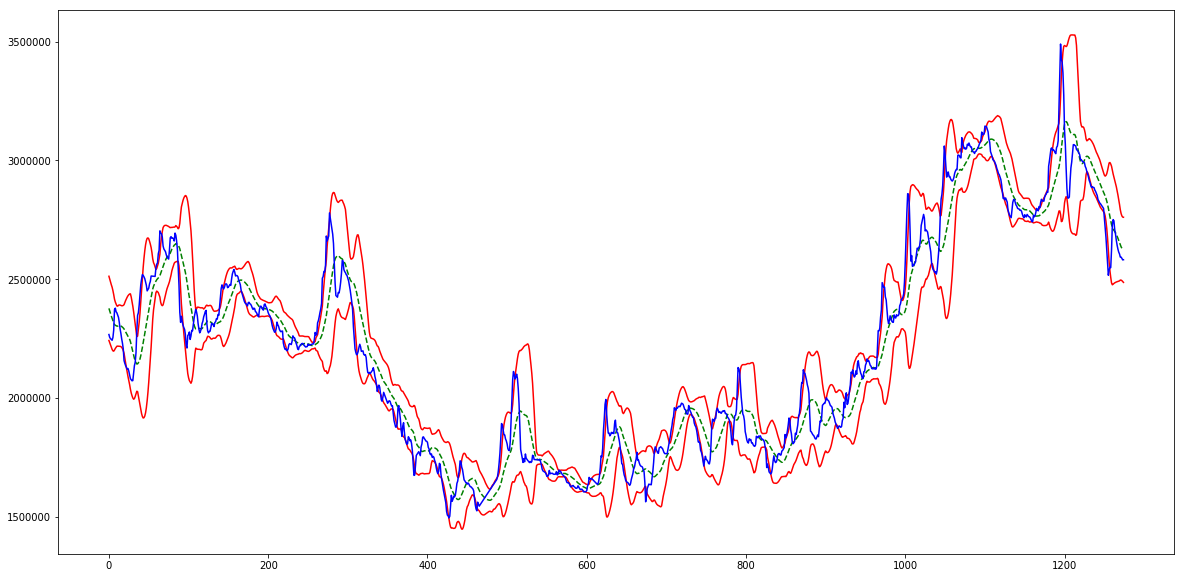

0.668390982455874


In [77]:
prices = [a[1] for a in itemPrices['Abyssal_whip']]
means,stds = bollingerBands(prices)
plotBollingerBands(prices,means,stds)
print(np.std(stds)/np.mean(stds))

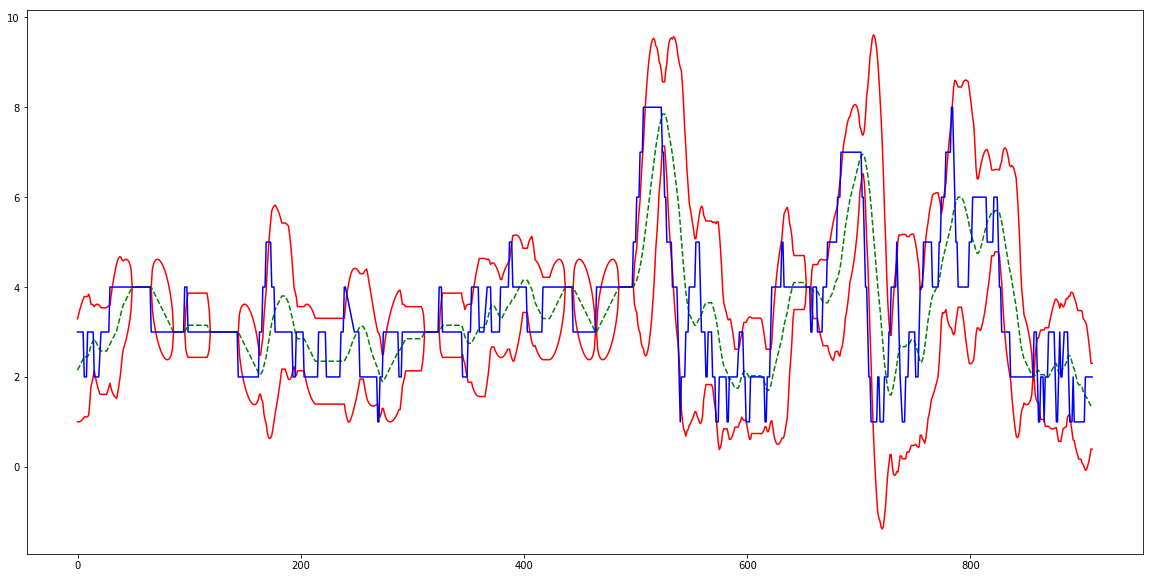

0.6794109100714467


In [78]:
prices = [a[1] for a in itemPrices['Body_tiara']]
means,stds = bollingerBands(prices)
plotBollingerBands(prices,means,stds)
print(np.std(stds)/np.mean(stds))

In [134]:
def perfectProfit(data,buyLimit):
    buyLimit = int(buyLimit)
    buyers = [10**5,10**6,10**7,10**8,10**9,10**10]
    invent = [0] * len(buyers)
    for i in range(1,len(data)):
        if data[i]>data[i-1]:
            for b in range(len(buyers)):
                buy = buyers[b]//data[i-1]
                if buy>buyLimit:
                    buy = buyLimit
                invent[b] += buy
                buyers[b] -= buy * data[i-1]
        elif data[i]<data[i-1]:
            for b in range(len(buyers)):
                buyers[b] += invent[b] * data[i-1]
                invent[b] = 0
    for b in range(len(buyers)):
        buyers[b] += invent[b] * data[i]
    init = [10**5,10**6,10**7,10**8,10**9,10**10]
    return [(buyers[i]-init[i])/init[i] for i in range(len(buyers))]

def buyAndHold(data,buyLimit):
    buyLimit = int(buyLimit)
    buyers = [10**5,10**6,10**7,10**8,10**9,10**10]
    invent = [0] * len(buyers)
    for b in range(len(buyers)):
        buy = buyers[b]//data[0]
        if buy>buyLimit:
            buy = buyLimit
        invent[b] += buy
        buyers[b] -= buy * data[0]
    for b in range(len(buyers)):
        buyers[b] += invent[b] * data[-1]
    init = [10**5,10**6,10**7,10**8,10**9,10**10]
    return [(buyers[i]-init[i])/init[i] for i in range(len(buyers))]

In [135]:
item = 'Abyssal_whip'
print(itemInfo[item])
bl = int(itemInfo[item]['buyLimit'])
prices = [a[1] for a in itemPrices[item]]
print(perfectProfit(prices[-90:],bl))
print(buyAndHold(prices[-90:],bl))

{'name': 'Abyssal_whip', 'image': '/w/File:Abyssal_whip.png', 'released': '26 January 2005', 'update': '/w/Update:Slayer_Skill', 'members': 'True', 'quest': 'No', 'tradeable': 'True', 'equipable': 'True', 'stackable': 'False', 'edible': 'False', 'noteable': 'True', 'destroy': 'Drop', 'storeprice': 'N/A', 'storeCurrency': 'N/A', 'seller': 'N/A', 'alchable': 'True', 'highAlch': '72000', 'lowAlch': '48000', 'exchangePrice': '2622266', 'buyLimit': '70', 'weight': '0.453', 'examine': 'A weapon from the abyss.'}
[0.0, 0.0, 0.3252564, 0.36046365, 0.216476323, 0.023374232]
[0.0, 0.0, -0.1382502, -0.14746688, -0.03225838, -0.003225838]


In [198]:
profits = {}
bAndH = {}
total = {}
j = 0
for item in viableItems:
    try:
        prices = [a[1] for a in itemPrices[item][-90:]]
        profits[item] = perfectProfit(prices,itemInfo[item]['buyLimit'])
        bAndH[item] = buyAndHold(prices,itemInfo[item]['buyLimit'])
        total[item] = []
        for i in range(len(bAndH[item])):
            if bAndH[item][i]!=0:
                total[item].append(profits[item][i]-bAndH[item][i])
            else:
                total[item].append(0.0)
    except ValueError:
        print(item)

Bullseye_lantern
Cooked_crab_meat
Dark_bow
Dragonfire_shield
Gilded_scimitar
Oil_lamp


In [199]:
for b in range(5):
    print(10**(5+b))
    p = sorted(profits.items(), key=lambda kv: kv[1][b],reverse=True)
    bAH = sorted(bAndH.items(), key=lambda kv: kv[1][b],reverse=True)
    t = sorted(total.items(), key=lambda kv: kv[1][b],reverse=True)
    print('\tPerfect')
    for i in range(0,5):
        print('\t\t',p[i][0],p[i][1][b])
    print('\tBuy and Hold')
    for i in range(0,5):
        print('\t\t',bAH[i][0],bAH[i][1][b])
    print('\tTotal')
    for i in range(0,5):
        print('\t\t',t[i][0],t[i][1][b])

100000
	Perfect
		 Royal_crown 8.82382
		 Mind_talisman 7.64979
		 Coconut 6.47975
		 Mushroom 5.93477
		 Spice 4.72028
	Buy and Hold
		 Coconut 2.09174
		 Fishing_potion(4) 1.8384
		 Jangerberries 1.56023
		 Silver_dust 1.339
		 Royal_crown 1.31283
	Total
		 Royal_crown 7.51099
		 Mind_talisman 6.40777
		 Mushroom 4.6309700000000005
		 Coconut 4.3880099999999995
		 Spice 4.21348
1000000
	Perfect
		 Royal_crown 9.670166
		 Mind_talisman 7.654684
		 Coconut 6.48872
		 Mushroom 5.855908
		 Mos_le'harmless_teleport 4.688595
	Buy and Hold
		 Coconut 2.098306
		 Jangerberries 1.561098
		 Ancient_chaps 1.411832
		 Karil's_leatherskirt_0 1.376244
		 Silver_dust 1.34017
	Total
		 Royal_crown 9.145034
		 Mind_talisman 6.41154
		 Mushroom 4.550263
		 Coconut 4.390414
		 Spice 4.042578499999999
10000000
	Perfect
		 Royal_crown 6.4492761
		 Coconut 5.4722556
		 Mind_talisman 5.220607
		 Mos_le'harmless_teleport 3.7996095
		 Mushroom 3.6321828
	Buy and Hold
		 Long_kebbit_spike 1.2663313
		 Coconut